# Implement probabilistic scores for ensemble forecasts
 
Now let's implement the ensemble scores. Please refer to the Dropbox document for their definition. 

1. Spread/Skill ratio: As mentioned in Scher and Messori (2020) there is a right way to do the order of the computations. Read their paragraph on it.
2. CRPS: Try the `properscoring` package. This one should be good.
3. Rank histogram: Try the `rankhistogram` package. No idea if this one is good. If it's ok but requires minor changes, we can consider a pull request. Otherwise, let's just write our own implementation. 

For all three scores:
- Use `xarray` as much as possible. Write a function similar to `src.score.compute_weighted_rmse.py`. 
- Ignore the weighted part at first.
- Create simple synthetic datasets to test extreme cases. E.g. `ensemble = [1, 1, 1]`, `obs=[1]` should result in a CRPS of 0. Think about what good sanity checks are for each score. For the rank histogram, for example, try to build examples that should end up in the shapes from the Dropbox document (overdispersion, underdispersion, etc.)
- Test the three functions with the "real" data from the dropout ensemble.
- Now the weighted part: Because the area of each lat-lon square is not the same but in fact varies with cos(lat), we want to weigh each grid point proportional to its area. This is already implemented for the rmse and acc scores in `src/score.py`. Implement this for the three probabilistic scores and compare to the unweighted scores. They shouldn't be too different. Implementing this for the rank histogram might require some thinking. We can talk about this together.

ToDo:
2. working with full data- Takes too long.
4. creating function to compare different models on CRPS, Spread-skill, RankHistogram. should be simple.

In [1]:
%load_ext autoreload
%autoreload 2

In [75]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import matplotlib.pyplot as plt

In [3]:
# # You only need this if you are using a GPU
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
# tf.compat.v1.disable_eager_execution() #needed
tf.__version__
!pwd

'2.0.0'

In [6]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/82-resnet_d3_dr_0.2.yml'
model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions'

In [7]:
start_date='2017-01-01'; end_date='2017-03-31'

In [ ]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/82-resnet_d3_dr_0.2.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

DG start 12:31:54.546372
DG normalize 12:31:54.560067
DG load 12:31:54.565431
Loading data into RAM
DG done 12:32:00.111220
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-01 12:32:00.326144: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-01 12:32:00.329854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-01 12:32:00.330319: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2020-05-01 12:32:00.330432: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-01 12:32:00.331054: I tensorflow/stream_executor/platform/default/

In [16]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'
!python create_dropout_ensemble.py 5 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

DG start 08:07:02.947798
DG normalize 08:07:02.961828
DG load 08:07:02.967287
Loading data into RAM
DG done 08:07:09.947820
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2020-05-03 08:07:10.174911: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-03 08:07:10.179236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1006] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-03 08:07:10.179724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:01:00.0
2020-05-03 08:07:10.179835: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-05-03 08:07:10.180530: I tensorflow/stream_executor/platform/default/

In [ ]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/80-resnet_d3_dr_0.05.yml'
!python create_dropout_ensemble.py 100 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir} {start_date} {end_date}

In [10]:
    exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'


    args=load_args(exp_id_path)
    exp_id=args['exp_id']
    var_dict=args['var_dict']
    batch_size=args['batch_size']
    output_vars=args['output_vars']
    
    #Question: how to optionally  input data_subsample, norm_subsample, nt_in, dt_in, test_years?
    data_subsample=args['data_subsample']
    norm_subsample=args['norm_subsample']
    nt_in=args['nt_in']
    dt_in=args['dt_in']
    test_years=args['test_years']
    lead_time=args['lead_time']
    

In [11]:
preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [12]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 5, time: 1042)
Coordinates:
  * member   (member) int64 0 1 2 3 4
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-03-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 ...
    t_850    (member, time, lat, lon) float64 ...

In [13]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't')

In [14]:
observation=xr.Dataset()
observation['z_500']=z500_valid
observation['t_850']=t850_valid

In [15]:
observation=observation.astype('float64')
observation=observation.drop('level')

In [16]:
# observation=observation.sel(time=preds.time)
# assert (observation.time==preds.time).all

In [17]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [18]:
observation.t_850.values[0:3,0,0] #unnormalized already

array([257.84133911, 257.58569336, 257.3553772 ])

In [34]:
tigge_dir='/home/garg/data/WeatherBench/tigge/5.625deg'
tigge_var_list=['geopotential_500_ens','temperature_850_ens']
#tigge_var_list=['temperature_850_ens']

tigge=xr.merge([xr.open_mfdataset(f'{tigge_dir}/{var}/*.nc'
                        , combine='by_coords') for var in tigge_var_list], compat="override")
#compat=override is dangerous. Any other way? the first coordinate: isobaricInhPa is different for both

tigge=xr.Dataset.rename(tigge,{'number':'member','gh':'z_500','t':'t_850'})

tigge=tigge.drop({'isobaricInhPa','valid_time'}) 

#What does step mean?
tigge['z_500']=tigge['z_500'].sel(step='3 days').drop('step')
tigge['t_850']=tigge['t_850'].sel(step='3 days').drop('step')

tigge=tigge.drop('step')

tigge

,Array,Chunk
Bytes,598.02 MB,25.40 MB
Shape,"(50, 1460, 32, 64)","(50, 62, 32, 64)"
Count,96 Tasks,24 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,598.02 MB,25.40 MB
Shape,"(50, 1460, 32, 64)","(50, 62, 32, 64)"
Count,96 Tasks,24 Chunks
Type,float32,numpy.ndarray


In [36]:
tigge.z_500.values[0:3,0,0,0,]  #Weird! its a magnitude smaller

array([5237.1724, 5256.6484, 5240.1006], dtype=float32)

# Evaluation methods: Spread-skill, CRPS, Rank histogram
check src/score.py.

In [ ]:
#Issues
#Spread-skill: 
#Ensure equal size of observation, tigge and preds.
    #Spread should be also only be counted on same 'time' as observation
#tigge data for z_500 is 1 magnitude smaller. 
#skill value worse than preds.

#CRPS :
#Ensure equal size of observation, tigge and preds.
#is unable to run on whole data at once. need to batch.
#if ran twice, throws error: 'Dataset' object is not callable.
#manually need to re-import modules.(Codecell 2)


#Rank histogram: 
#Ensure equal size of observation, tigge and preds.
#takes too much time.

In [69]:
##Ensure equal size of observation, tigge and preds. Better way?
obs2=observation.sel(time=preds.time) #for preds
obs3=observation.sel(time=tigge.time)
tigge_small=tigge.sel(member=slice(0,5))

In [70]:
#Spread-skill for PREDS
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)
ensemblemean=preds.mean('member')
mean_rmse=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse)

#spread_skill_ratio=mean_spread/mean_rmse; print(spread_skill_ratio)
spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) 
#CouldDo: make a single Dataset by keeping same name as z500, t850
#So spread is low compared to RMSE. That means a over confident prediction?

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 119.0
    t_850_mean_spread  float64 0.5816
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 334.2
    t_850_rmse  float64 1.882
<xarray.DataArray ()>
array(0.3559985)
<xarray.DataArray ()>
array(0.30900157)


In [71]:
#Spread-Skill for TIGGE. Full Observation
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(tigge).load(); print(mean_spread)
ensemblemean=tigge.mean('member')
mean_rmse=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500) #WRONG!!
print(spread_skill_ratio_t850) 

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 15.51
    t_850_mean_spread  float64 1.116
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 4.999e+04
    t_850_rmse  float64 4.169
<xarray.DataArray ()>
array(0.00031028)
<xarray.DataArray ()>
array(0.26759205)


In [37]:
print(tigge.t_850.values[0:3,0,0,0])
print(observation.t_850.values[0:3,0,0])

print(tigge.z_500.values[0:3,0,0,0])
print(observation.z_500.values[0:3,0,0]) #A magnitude smaller!!

[258.87042 259.60455 258.81906]
[257.84133911 257.58569336 257.3553772 ]
[5237.1724 5256.6484 5240.1006]
[50954.625   50946.96875 50954.625  ]


In [73]:
#Spread-Skill for TIGGE_SMALL.
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(tigge_small).load(); print(mean_spread)
ensemblemean=tigge_small.mean('member')
mean_rmse=compute_weighted_rmse(obs3,ensemblemean).load(); print(mean_rmse)

spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500) #WRONG!!
print(spread_skill_ratio_t850) 

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 14.72
    t_850_mean_spread  float64 1.033
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 4.999e+04
    t_850_rmse  float64 4.19
<xarray.DataArray ()>
array(0.00029452)
<xarray.DataArray ()>
array(0.2465453)


# Method 2: CRPS

In [80]:
#Method 2: Continuous Ranked Probablity Score (properscoring package)
from src.score import * #ToDo: Need to re-load everytime.
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
crps_score=crps_score(preds, observation,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 180.9
    t850     float64 1.124


In [81]:
from src.score import *
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
crps_score=crps_score(preds, obs2,member_axis); print(crps_score)
#Works without reducing observation size. since condition added in crps function. check score.py

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 180.9
    t850     float64 1.124


In [82]:
#FOR TIGGE. full data. throws space error.
from src.score import *
member_axis=xr.DataArray.get_axis_num(tigge.z_500,'member')
crps_score=crps_score(tigge, obs3,member_axis).load(); print(crps_score)

MemoryError: Unable to allocate 55.7 GiB for an array with shape (2, 1460, 32, 64, 50, 50) and data type float32

In [83]:
#FOR TIGGE_small
from src.score import *
member_axis=xr.DataArray.get_axis_num(tigge_small.z_500,'member')
crps_score=crps_score(tigge_small, observation,member_axis).load(); print(crps_score)
#Why would score be worse for t850?

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 4.992e+04
    t850     float64 2.498


In [84]:
#sanity check. MAE=crps for 1 ensemble member
from src.score import *
obs_single=observation
pred_single=preds.isel(member=0)

#mean absolute error
mae=compute_weighted_mae(pred_single,obs_single).load(); print(mae)
#crps for single
crps_score_single=crps_score(pred_single,obs_single,member_axis); print(crps_score_single)
#ToDo: solve this error. unable to call crps_score function twice. 
#if i re-run cell block 2 (from src.score import *), then it runs fine. 
#possibly becasue  change datatype by calling to_array() function

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    member     int64 0
Data variables:
    z_500_mae  float64 229.3
    t_850_mae  float64 1.377
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 229.3
    t850     float64 1.377


In [85]:
#Sanity Check for TIGGE
from src.score import *
obs_single=observation
pred_single=tigge.isel(member=0)

#mean absolute error
mae=compute_weighted_mae(pred_single,obs_single).load(); print(mae)
#crps for single
crps_score_single=crps_score(pred_single,obs_single,member_axis); print(crps_score_single)

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    member     int64 1
Data variables:
    z_500_mae  float64 4.993e+04
    t_850_mae  float64 2.943
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 4.993e+04
    t850     float64 2.943


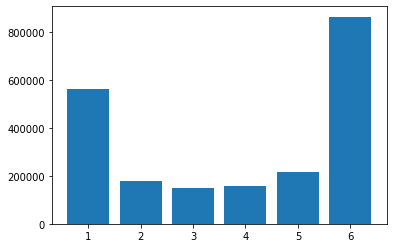

In [88]:
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

#obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze(); #Full data. #DOES NOT WORK if dimensions dont match
obs = np.asarray(obs2.to_array(), dtype=np.float32).squeeze();#small data

obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

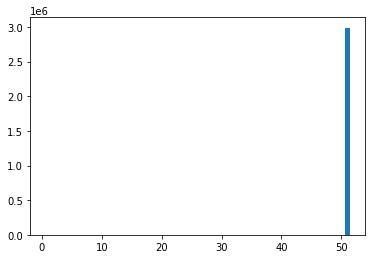

In [90]:
#FOr TIGGE. SLOW!!
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(obs3.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(tigge.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

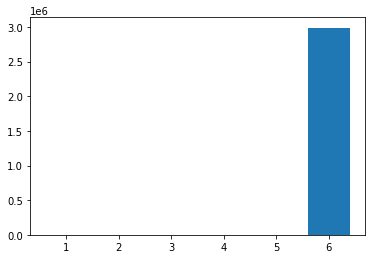

In [91]:
#FOr TIGGE_small
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(obs3.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(tigge_small.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

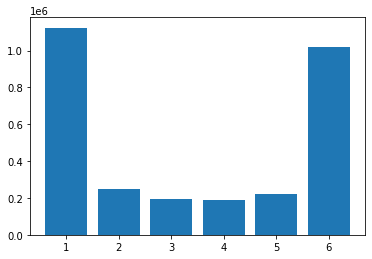

In [96]:
#For Temperature. Should be better.
result = rankz(obs_t850, pred_t850, mask)
# plot histogram
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

In [ ]:
#result from old code with 50 forecasts. just to show it is still overconfident
result = rankz(obs_t850, pred_t850, mask)
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
plt.show()

In [ ]:
#sanity check: for a random sample
obs = np.random.randn(10, 40, 40)
ensemble = np.random.randn(20, 10, 40, 40)
mask = np.random.randint(0, 2, (10, 40, 40)) #masked where 0/false.
# feed into rankz function
result = rankz(obs, ensemble, mask)
# plot histogram
plt.bar(range(1,ensemble.shape[0]+2), result[0])
# view histogram
plt.show()

In [ ]:
#testing for smaller number of bins (i.e. forecasts) (For old predictions.)
obs_small=obs_z500[:,:,:].squeeze()
pred_small=pred_z500[0:10,:,:,:]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show() #overconfident (underdispersive)